# CTCF binding sites on conserved boundaries

In [1]:
import pandas as pd
import numpy as np
import src
import warnings
import os
warnings.filterwarnings("ignore", category=FutureWarning)

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

figure_path = src.figures_path / "ctcfs_on_boundaries"
os.makedirs(figure_path, exist_ok=True)

ctcf_class_colormap = {
    'S': '#FF6978',
    'C': '#3B3561',
    'D': '#768A77',
    'CD': '#CBC5EA'
}

ctcf_class_to_name = {
    'S': 'Same',
    'C': 'Convergent',
    'D': 'Divergent',
    'CD': 'Convergent-Divergent'
}

ctcf_name_colormap = {n:ctcf_class_colormap[c] for c,n in ctcf_class_to_name.items()}

cleanup()

In [2]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcfs_with_context.tsv", sep="\t")
ctcfs = pd.concat((ctcfs, pd.get_dummies(ctcfs[['orientation','context']], prefix="", prefix_sep="")), axis=1)
ctcfs = ctcfs.rename(columns={'>': 'forward', '<': 'reverse'})
ctcfs = ctcfs.merge(pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t"), on=src.coords + ['orientation'])
ctcfs.head()

,chr,start,end,orientation,context,reverse,forward,C,CD,D,S,T,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,T,0,1,0,0,0,0,1,0,9.790746,12.639115,1.502743e+09
1,chr1,521337,521697,>,S,0,1,0,0,0,1,0,1,10.259412,13.836791,1.680162e+09
2,chr1,714087,714447,>,S,0,1,0,0,0,1,0,2,9.893988,9.326291,1.342770e+09
3,chr1,805232,805362,>,S,0,1,0,0,0,1,0,3,14.365820,46.641218,3.446545e+09
4,chr1,839966,840326,>,S,0,1,0,0,0,1,0,4,16.393501,60.468042,3.756117e+09


In [3]:
window = 25000
consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / "consensus_boundaries_w{}.tsv".format(window), sep = "\t")
consensus_boundaries['consensus_boundary_uid'] = np.arange(consensus_boundaries.shape[0], dtype=int)
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4


## Plotting CTCF binding sites around boundaries

In [4]:
extended = 250*1000
window_size = 5*1000

centered_boundaries = consensus_boundaries.copy()
centers = ((centered_boundaries.start + centered_boundaries.end)/2).astype(int)
centered_boundaries['start'] = centers
centered_boundaries['end'] = centers

centered_boundaries = BedTool.from_dataframe(centered_boundaries).slop(b=extended, genome='hg19').to_dataframe(names=centered_boundaries.columns)

In [5]:
def windowing_by_size(centered_boundaries, window_size=window_size):    
    windows = BedTool().window_maker(b=BedTool.from_dataframe(centered_boundaries), 
                                     w=window_size, i='srcwinnum')\
                       .to_dataframe(names=centered_boundaries.columns.tolist())
    idxs = windows[centered_boundaries.columns[-1]].str.split("_", expand=True)
    tad_ids = idxs.iloc[:, :-1].apply(lambda x: "_".join(x), axis=1)
    w_nums = idxs.iloc[:, -1].astype(int) - 1
    windows[centered_boundaries.columns[-1]] = tad_ids
    windows['w_num'] = w_nums
    windows = windows.sort_values(src.coords).reset_index(drop=True)
    return windows

In [6]:
centered_boundaries = centered_boundaries[centered_boundaries.end - centered_boundaries.start == extended*2]
windows = windowing_by_size(centered_boundaries[src.coords + ['consensus_boundary_uid']], window_size=window_size)

In [7]:
aggregations = {'ctcf_id': 'count', 
                'forward': 'sum', 
                'reverse': 'sum',
                'S': 'sum',
                'CD': 'sum', 
                'D': 'sum',
                'C': 'sum'}


windows_with_ctcf = src.coverage_by_window(windows, ctcfs, aggregations)
windows_with_ctcf = windows_with_ctcf.merge(consensus_boundaries.drop(src.coords, axis=1), on='consensus_boundary_uid')

In [8]:
aggregations_by_bound = {}
for nc in src.progress(sorted(windows_with_ctcf.n_cell_types.unique())):
    lw = windows_with_ctcf[windows_with_ctcf.n_cell_types == nc]
    for c in src.progress(aggregations.keys()):
        cagg = lw.pivot_table(index='consensus_boundary_uid', columns='w_num', values=c).sort_index(axis=1)
        cagg = cagg.sort_index(axis=1)
        aggregations_by_bound[(nc, c)] = cagg

In [9]:
aggregations_by_bound_tot = {}
for c in src.progress(aggregations.keys()):
    cagg = windows_with_ctcf.pivot_table(index='consensus_boundary_uid', columns='w_num', values=c).sort_index(axis=1)
    cagg = cagg.sort_index(axis=1)
    aggregations_by_bound_tot[c] = cagg 

### On all consensus boundaries

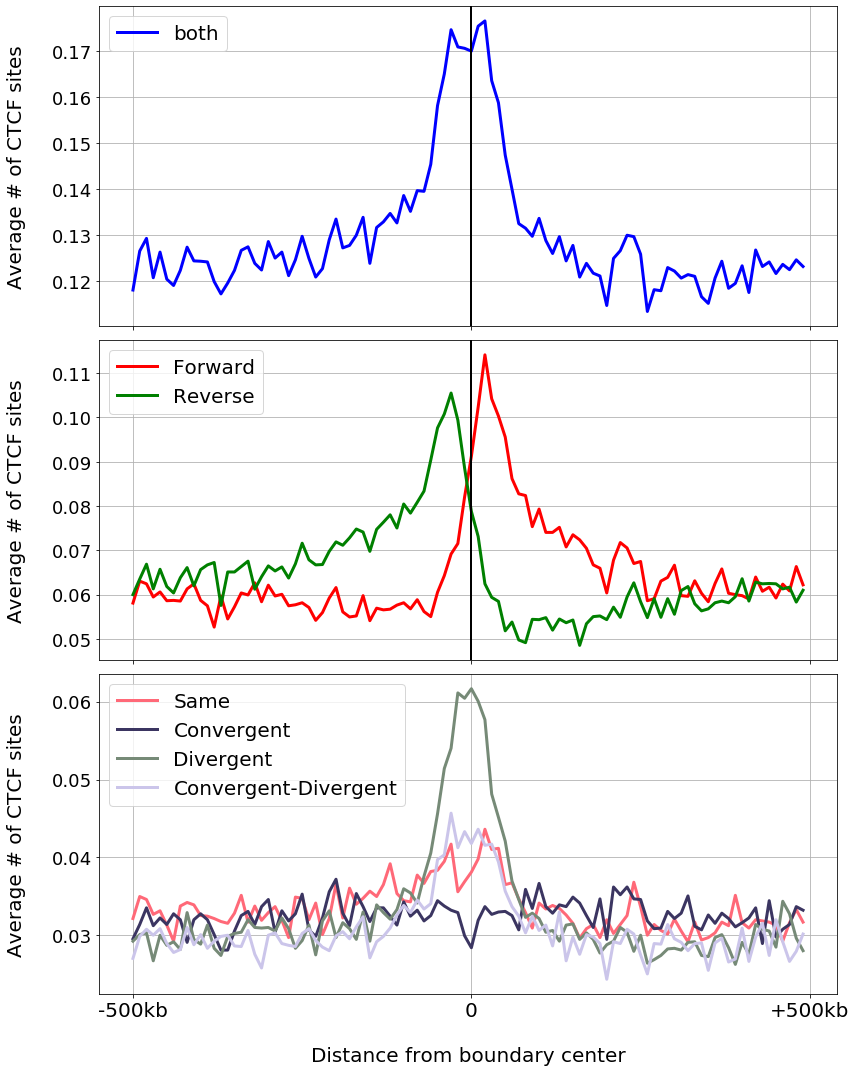

In [10]:
linewidth=3
legendfont = 20
labelfont = 20
tickfont = 20

fig, axes = plt.subplots(3,1,sharex=True,figsize=(12, 15), tight_layout=True)
axes[0].plot(aggregations_by_bound_tot['ctcf_id'].mean(0), linewidth=linewidth, label='both', color='blue')
axes[0].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
axes[0].axvline(extended/window_size, color='black')
axes[0].grid()
axes[0].legend(loc='upper left', fontsize=legendfont)

axes[1].plot(aggregations_by_bound_tot['forward'].mean(0), linewidth=linewidth, label='Forward', color='red')
axes[1].plot(aggregations_by_bound_tot['reverse'].mean(0), linewidth=linewidth, label='Reverse', color='green')
axes[1].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
axes[1].axvline(extended/window_size, color='black')
axes[1].grid()
axes[1].legend(loc='upper left', fontsize=legendfont)

axes[2].plot(aggregations_by_bound_tot['S'].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
axes[2].plot(aggregations_by_bound_tot['C'].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
axes[2].plot(aggregations_by_bound_tot['D'].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
axes[2].plot(aggregations_by_bound_tot['CD'].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
axes[2].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
# axes[2].axvline(extension/resolution, color='black')
axes[2].grid()
axes[2].legend(loc='upper left', fontsize=legendfont)

axes[2].set_xticks([0, extended/window_size, extended*2/window_size])
axes[2].set_xticklabels(['-500kb', '0', '+500kb'], fontsize=tickfont)
axes[2].set_xlabel("\nDistance from boundary center", fontsize=labelfont)

# plt.xticks([0, extended/window_size ,extended*2/window_size], labels=['-500kb', 'Boundary center', '+500kb'])
# plt.xlabel("\nPosition", fontsize=20)
fig.savefig(figure_path / "avg_ctcf_sites_on_bounds_by_window.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Stratifying by boundary conservation score

In [11]:
# for mc in range(1, 8):
#     wc = windows_with_ctcf[windows_with_ctcf.n_cell_types >= mc]
#     wc_count = wc.pivot_table(index='consensus_boundary_uid', columns='w_num', values='ctcf_id').sort_index(axis=1)
#     wc_forward = wc.pivot_table(index='consensus_boundary_uid', columns='w_num', values='forward').sort_index(axis=1)
#     wc_reverse = wc.pivot_table(index='consensus_boundary_uid', columns='w_num', values='reverse').sort_index(axis=1)
    
#     fig, axes = plt.subplots(2,1,sharex=True,figsize=(10, 10))
#     axes[0].plot(wc_count.mean(0), linewidth=5, label='both', color='blue')
#     axes[0].set_ylabel("Average # of CTCF sites", fontsize=20)
#     axes[0].axvline(extended/window_size, color='black')
#     axes[0].set_ylim(0.1, 0.3)
#     axes[0].grid()
#     axes[0].legend(loc='upper left', fontsize=20)

#     axes[1].plot(wc_forward.mean(0), linewidth=5, label='Forward', color='red')
#     axes[1].plot(wc_reverse.mean(0), linewidth=5, label='Reverse', color='green')
#     axes[1].set_ylabel("Average # of CTCF sites", fontsize=20)
#     axes[1].axvline(extended/window_size, color='black')
#     axes[1].set_ylim(0.0, 0.2)
#     axes[1].grid()
#     axes[1].legend(loc='upper left', fontsize=20)

#     plt.xticks([0, extended/window_size ,extended*2/window_size], labels=['-500kb', 'Boundary center', '+500kb'])
#     plt.xlabel("\nPosition", fontsize=20)
#     fig.suptitle("$s \geq {}$".format(mc), x=0.5, y=1.05, fontsize=30)
#     plt.show()

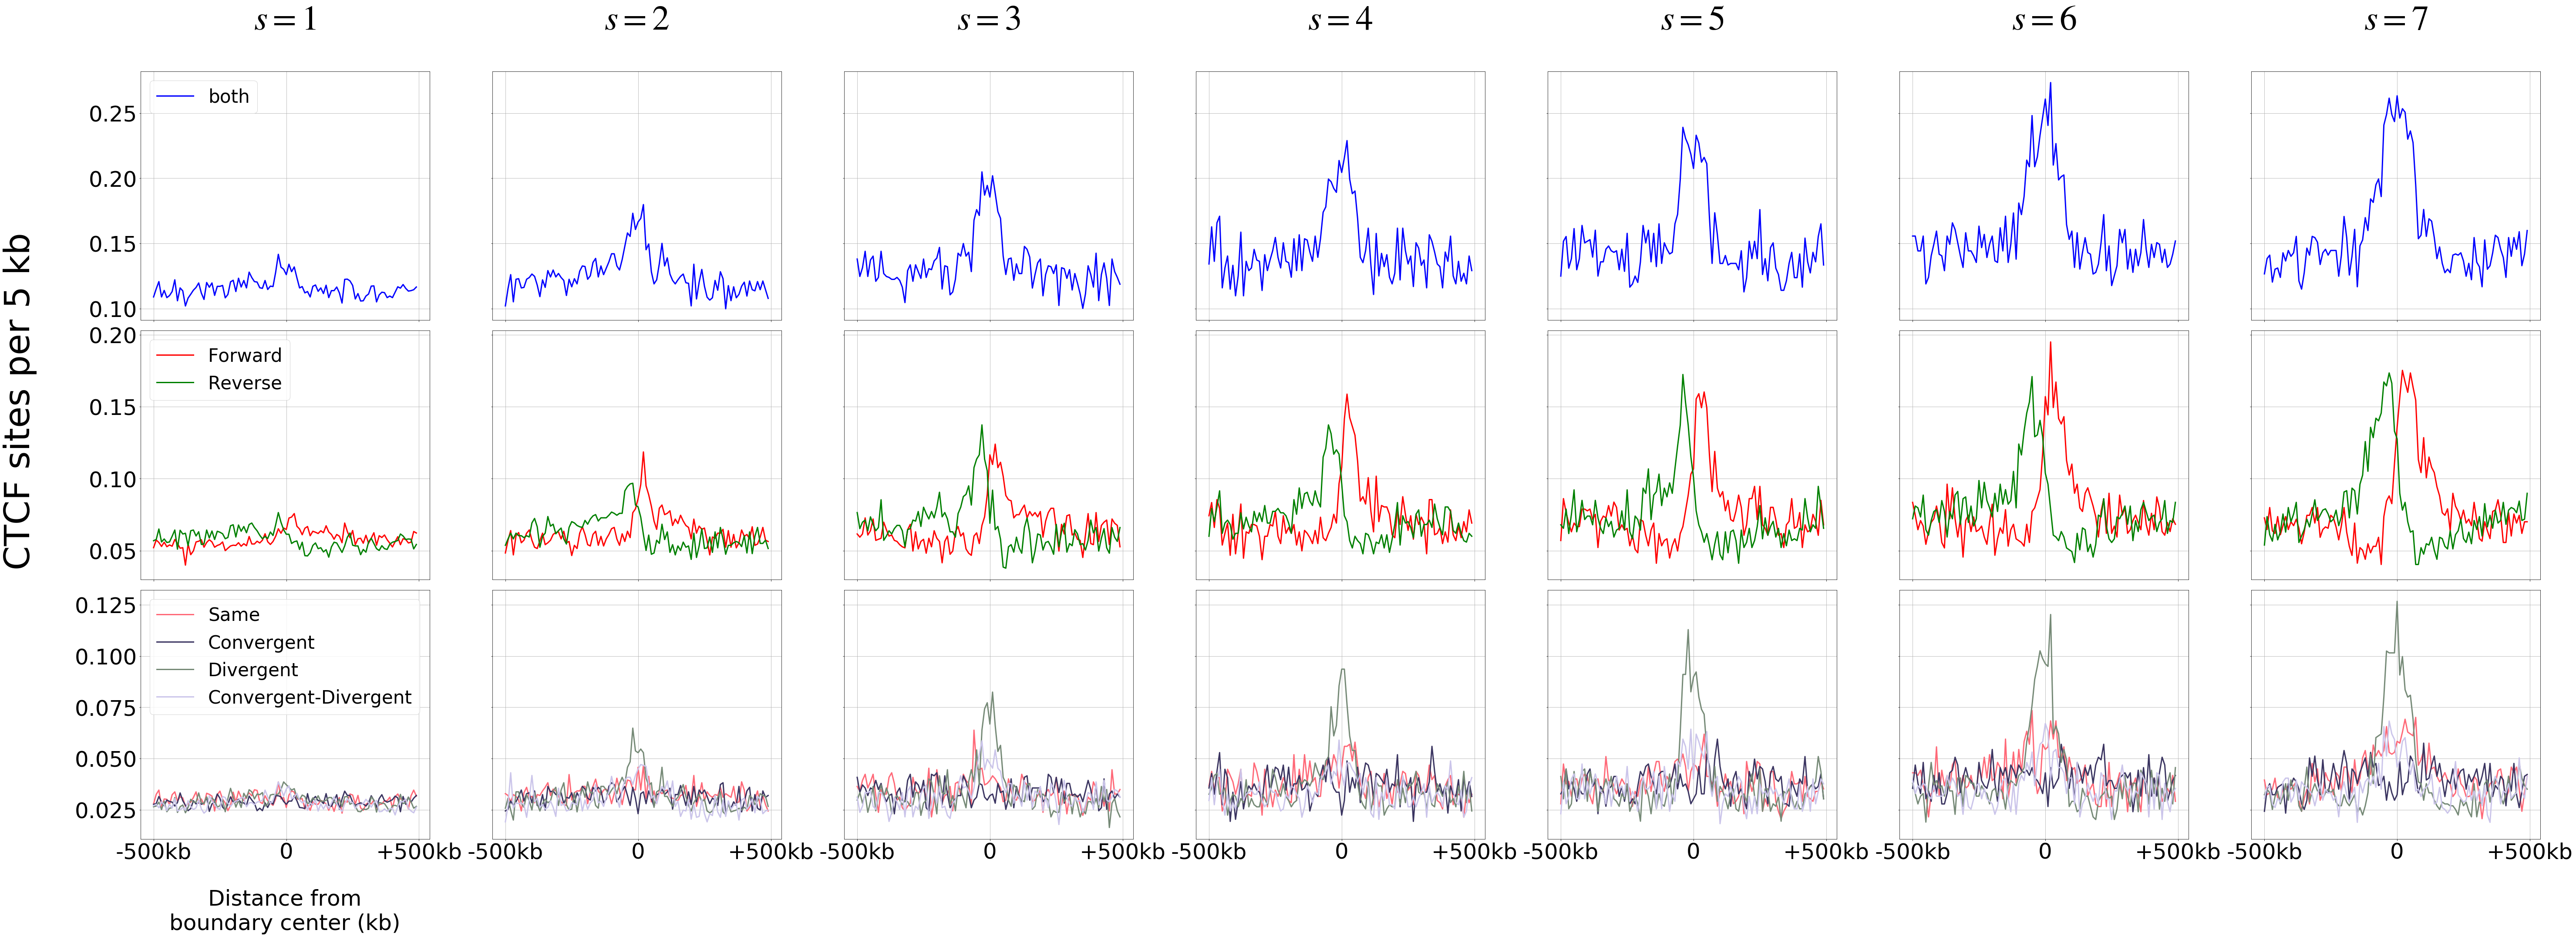

In [35]:
linewidth=3
legendfont = 42
titlefont = 80
labelfont = 40
tickfont = 50

fig, axes = plt.subplots(3,len(windows_with_ctcf.n_cell_types.unique()),sharex='col', sharey='row',tight_layout=True, figsize=(80, 30))
for level in sorted(windows_with_ctcf.n_cell_types.unique()):
    
    axes[0, level - 1].plot(aggregations_by_bound[(level,'ctcf_id')].mean(0), linewidth=linewidth, label='both', color='blue')
    if level == 1:
        axes[0, level - 1].legend(fontsize=legendfont, loc='upper left')
    else:
        axes[0, level - 1].legend().set_visible(False)
#         axes[0, level - 1].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
    # axes[0].axvline(extension/resolution, color='black')
    axes[0, level - 1].grid()
    axes[0, level - 1].set_title("$s = {}$\n".format(level), fontsize=titlefont, fontweight="bold")
    axes[0, level - 1].tick_params(axis='y', labelsize=tickfont)

    axes[1, level - 1].plot(aggregations_by_bound[(level,'forward')].mean(0), linewidth=linewidth, label='Forward', color='red')
    axes[1, level - 1].plot(aggregations_by_bound[(level,'reverse')].mean(0), linewidth=linewidth, label='Reverse', color='green')
    axes[1, level - 1].tick_params(axis='y', labelsize=tickfont)
    if level == 1:
        axes[1, level - 1].legend(fontsize=legendfont, loc='upper left')
    else:
        axes[1, level - 1].legend().set_visible(False)
#         axes[1, level - 1].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
    # axes[1].axvline(extension/resolution, color='black')
    axes[1, level - 1].grid()
    axes[2, level - 1].plot(aggregations_by_bound[(level,'S')].mean(0), linewidth=linewidth, label='Same', color='#FF6978')
    axes[2, level - 1].plot(aggregations_by_bound[(level,'C')].mean(0), linewidth=linewidth, label='Convergent', color='#3B3561')
    axes[2, level - 1].plot(aggregations_by_bound[(level,'D')].mean(0), linewidth=linewidth, label='Divergent', color='#768A77')
    axes[2, level - 1].plot(aggregations_by_bound[(level,'CD')].mean(0), linewidth=linewidth, label='Convergent-Divergent', color='#CBC5EA')
    if level == 1:
        axes[2, level - 1].legend(fontsize=legendfont, loc='upper left')
    else:
        axes[2, level - 1].legend().set_visible(False)
#         axes[2, level - 1].set_ylabel("Average # of CTCF sites\n", fontsize=labelfont)
    # axes[2].axvline(extension/resolution, color='black')
    axes[2, level - 1].grid()
    axes[2, level - 1].tick_params(axis='y', labelsize=tickfont)
    
    axes[2, level - 1].set_xticks([0, extended/window_size, extended*2/window_size])
    axes[2, level - 1].set_xticklabels(['-500kb', '0', '+500kb'], fontsize=tickfont)
    if level == 1:
        axes[2, level - 1].set_xlabel("\nDistance from\nboundary center (kb)", fontsize=50)
# fig.suptitle("Level {}".format(level), x=0.54, y=1.01, horizontalalignment='center', fontsize=25)
fig.text(x=-0.02, y=0.4, rotation=90, ha='center', s="CTCF sites per 5 kb", fontsize=80)
fig.savefig(figure_path / "avg_ctcf_sites_on_bounds_by_conservation.pdf", bbox_inches='tight', transparent=True)
plt.show()
    

## Counting how many CTCF binding sites are in boundaries

In [21]:
ctcfs_with_bounds = BedTool.from_dataframe(ctcfs)\
                            .closest(BedTool.from_dataframe(consensus_boundaries), d=True, t='first')\
                            .to_dataframe(names=ctcfs.columns.tolist() + consensus_boundaries.columns.map(lambda x: "bound_" + x).tolist() + ['distance'])
ctcfs_with_bounds.head()

,chr,start,end,orientation,context,reverse,forward,C,CD,D,...,bound_MK,bound_Mac0,bound_Mon,bound_nB,bound_nCD4,bound_nCD8,bound_length,bound_covered_genome,bound_consensus_boundary_uid,distance
0,chr1,237593,237953,>,T,0,1,0,0,0,...,0,0,1,0,0,0,1,3.223947e-10,0,1374547
1,chr1,521337,521697,>,S,0,1,0,0,0,...,0,0,1,0,0,0,1,3.223947e-10,0,1090803
2,chr1,714087,714447,>,S,0,1,0,0,0,...,0,0,1,0,0,0,1,3.223947e-10,0,898053
3,chr1,805232,805362,>,S,0,1,0,0,0,...,0,0,1,0,0,0,1,3.223947e-10,0,807138
4,chr1,839966,840326,>,S,0,1,0,0,0,...,0,0,1,0,0,0,1,3.223947e-10,0,772174


## Counting how many Boundaries have CTCF sites

In [22]:
consensus_boundaries_noY = consensus_boundaries[consensus_boundaries.chr != 'chrY']

In [23]:
bounds_with_ctcf = BedTool.from_dataframe(consensus_boundaries_noY)\
                            .closest(BedTool.from_dataframe(ctcfs), d=True, t='first')\
                            .to_dataframe(names=consensus_boundaries_noY.columns.tolist() + ctcfs.columns.map(lambda x: "ctcf_" + x).tolist() + ['distance'])
# bounds_with_ctcf['has_ctcf'] = bounds_with_ctcf.n_ctcfs > 0
bounds_with_ctcf.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,ctcf_C,ctcf_CD,ctcf_D,ctcf_S,ctcf_T,ctcf_ctcf_id,ctcf_MotifScore,ctcf_ChipSeqScore,ctcf_rank_score_aggregate,distance
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,...,0,0,0,1,0,67,5.455657,14.842673,6.282358e+08,1798
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,...,0,0,1,0,0,68,8.624401,26.714164,1.566253e+09,9089
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,...,0,0,0,1,0,81,10.029155,28.088145,2.040015e+09,1781
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,...,0,0,1,0,0,95,16.645338,60.078033,3.756626e+09,6412
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,...,0,1,0,0,0,105,7.809072,1.356036,2.407459e+08,0


In [26]:
max_distance = 25000
bounds_with_ctcf_count = BedTool.from_dataframe(consensus_boundaries_noY)\
                                .slop(b=max_distance, genome='hg19')\
                                .map(BedTool.from_dataframe(ctcfs), c=4, o='count')\
                                .to_dataframe(names=consensus_boundaries_noY.columns.tolist() + ['n_ctcfs'])
bounds_with_ctcf_count.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome,consensus_boundary_uid,n_ctcfs
0,chr1,1587500,1637500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10,0,3
1,chr1,1621875,1671875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10,1,1
2,chr1,1817500,1872500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,1,1,0,0,5001,1.612296e-06,2,4
3,chr1,2087500,2137500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10,3,3
4,chr1,2317500,2375000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,0,2,0,1,7501,2.418282e-06,4,4


In [27]:
def __to_bin(x):
    if x in [0,1,2]:
        return str(x)
    elif x in [3,4]:
        return "3-4"
    elif x in range(5,9):
        return "5-8"
    elif x in range(9,17):
        return "9-16"

bounds_with_ctcf_count['cat'] = bounds_with_ctcf_count.n_ctcfs.map(__to_bin)
bounds_with_ctcf_count = pd.concat((bounds_with_ctcf_count, pd.get_dummies(bounds_with_ctcf_count.cat)), axis=1)
bounds_with_ctcf_count.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,...,covered_genome,consensus_boundary_uid,n_ctcfs,cat,0,1,2,3-4,5-8,9-16
0,chr1,1587500,1637500,Mon_0000_start,Mon,1,1,0,0,0,...,3.223947e-10,0,3,3-4,0,0,0,1,0,0
1,chr1,1621875,1671875,nB_0000_start,nB,1,1,0,0,0,...,3.223947e-10,1,1,1,0,1,0,0,0,0
2,chr1,1817500,1872500,"nB_0000_end,Ery_0000_start,Mon_0000_end","nB,Mon,Ery",3,3,1,0,0,...,1.612296e-06,2,4,3-4,0,0,0,1,0,0
3,chr1,2087500,2137500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,...,3.223947e-10,3,3,3-4,0,0,0,1,0,0
4,chr1,2317500,2375000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nB,Ery,Mac0,nCD8",4,5,1,0,1,...,2.418282e-06,4,4,3-4,0,0,0,1,0,0


In [28]:
bounds_with_ctcf_count.n_ctcfs.max()

16

In [29]:
groups = bounds_with_ctcf_count.groupby('n_cell_types')[['0', '1', '2', '3-4', '5-8', '9-16']].sum()
groups.head()

,0,1,2,3-4,5-8,9-16
n_cell_types,,,,,,
1,2229.0,1665.0,976.0,717.0,183.0,3.0
2,592.0,592.0,467.0,443.0,149.0,12.0
3,272.0,294.0,284.0,348.0,149.0,6.0
4,123.0,206.0,196.0,292.0,161.0,5.0
5,72.0,117.0,183.0,282.0,161.0,13.0


In [30]:
cmap = plt.cm.get_cmap('Blues', 8)
newcolors = cmap(np.linspace(0,1,8))
blue = np.array([1,1,1, 1])
newcolors[0, :] = blue
newcmp = ListedColormap(newcolors)

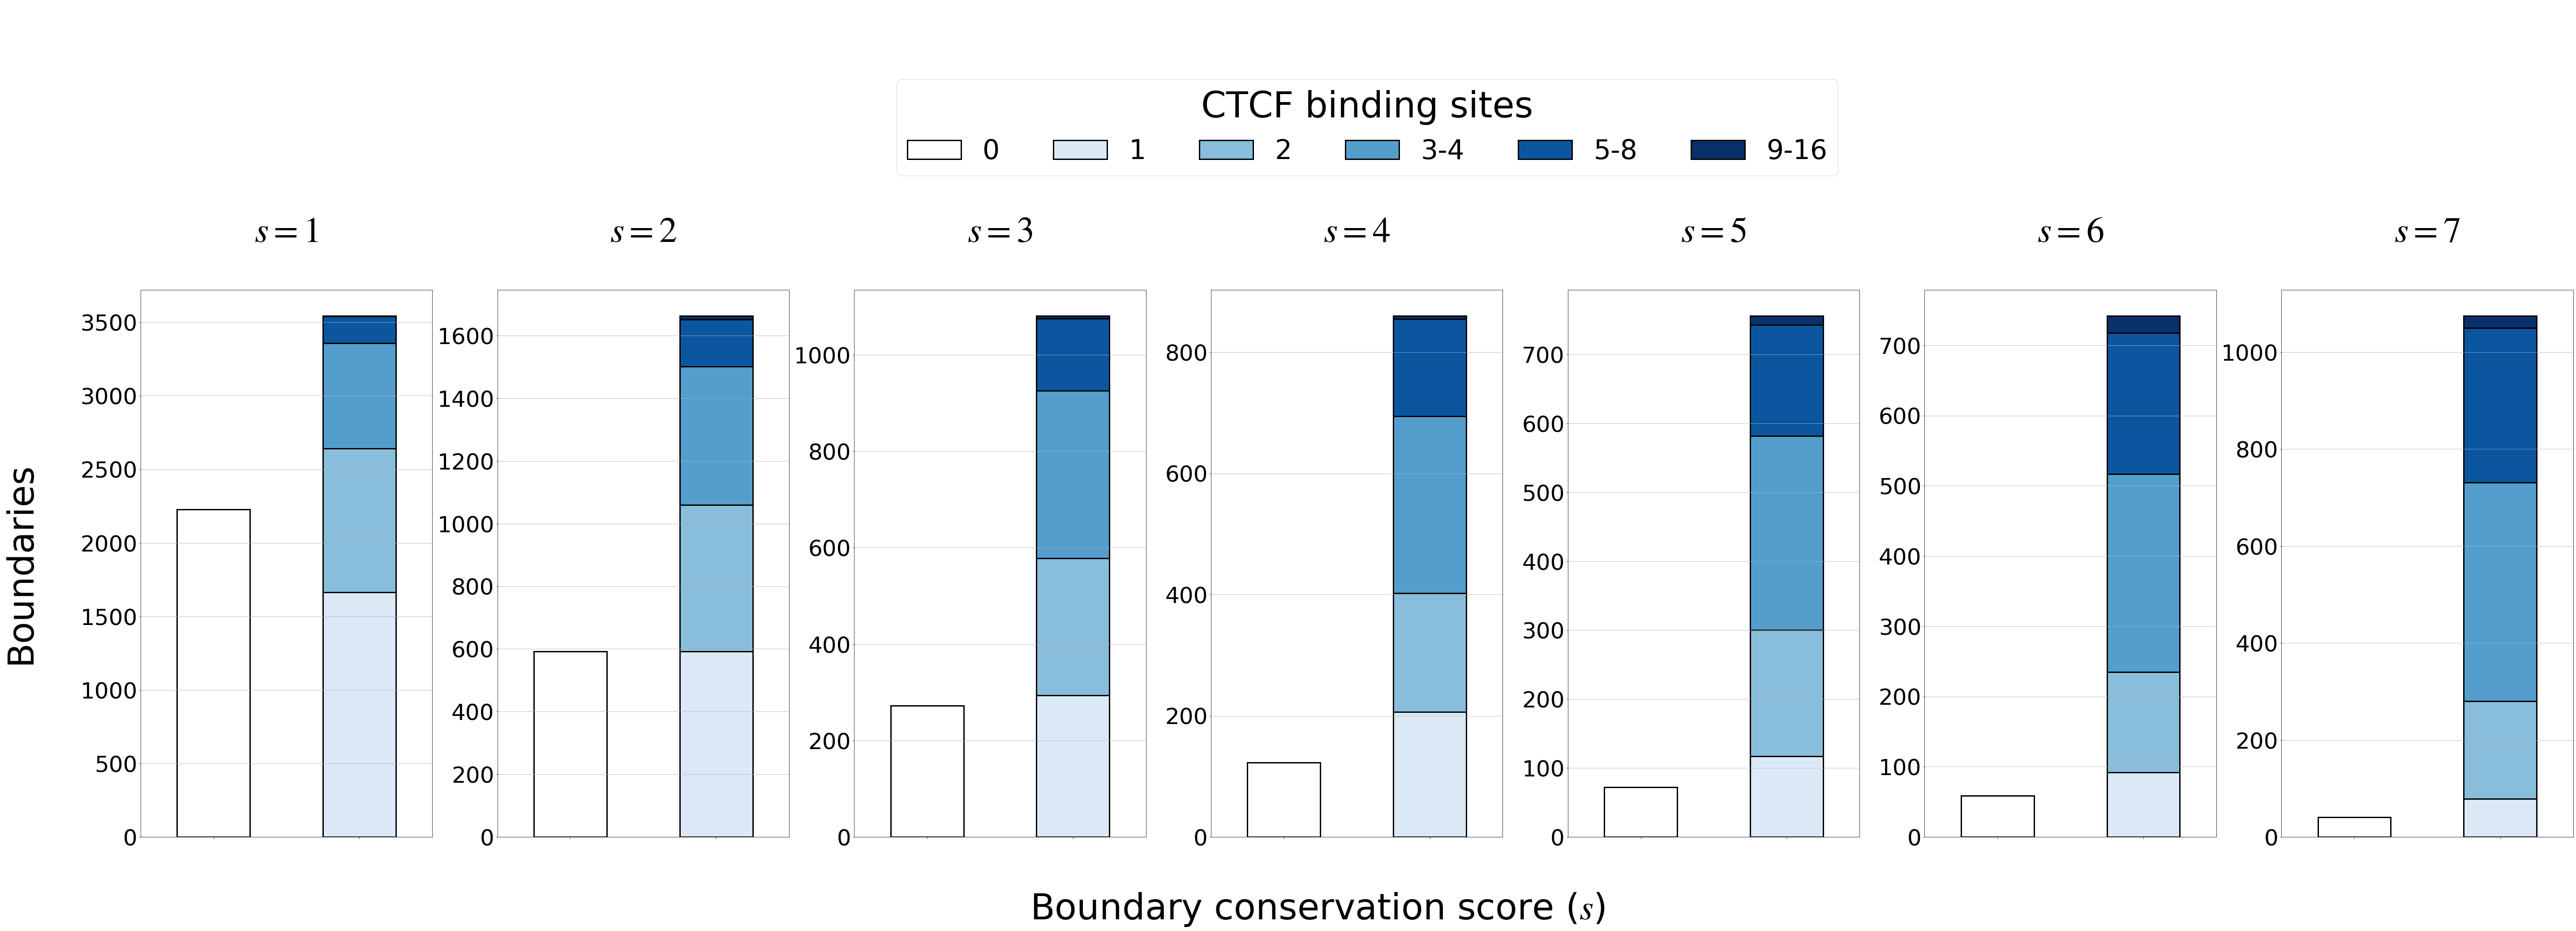

In [40]:
fig, axes = plt.subplots(1, 7, figsize=(80, 20),tight_layout=True)
for i, g in enumerate(range(1,8)):
    xg = groups.loc[[g], ['1', '2', '3-4', '5-8', '9-16']]
    xg.loc['0', '0'] = groups.loc[g, '0']
    xg = xg.fillna(0)
    xg.loc[g, 'not_intersect'] = 0
    xg = xg.loc[['0', g], ['0', '1', '2', '3-4', '5-8', '9-16']]
    xg.plot.bar(stacked=True, cmap=newcmp, ax=axes[i],edgecolor='black', linewidth=3)
    axes[i].legend().set_visible(False)
    axes[i].set_xticklabels([])
    axes[i].grid(axis="y")
    axes[i].tick_params(axis='y', labelsize=tickfont)
    axes[i].set_xlabel("")
    axes[i].set_title("$s = {}$\n".format(g), fontsize=titlefont, fontweight="bold")
axes[0].set_ylabel("Boundaries\n", fontsize=80)
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=8, 
           bbox_to_anchor=(0.53,1.15), fontsize=60, 
           title='CTCF binding sites', title_fontsize=80)
fig.text(x=0.4, y=-0.1, s="Boundary conservation score ($s$)", fontsize=80)
plt.show()

In [ ]:
max_distance = 25000
min_conservation = 2
selbounds = bounds_with_ctcf[(bounds_with_ctcf.n_cell_types >= min_conservation)]
selbounds['has_ctcf'] = selbounds.distance <= max_distance

selbounds.has_ctcf.value_counts().to_frame().T.rename(columns={True: 'Boundaries with CTCF', 
                                                               False: "Boundaries without CTCF"})[["Boundaries without CTCF", 'Boundaries with CTCF']].plot.bar(stacked=True, figsize=(4,10))
plt.xticks([])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.03), fontsize=20, title="$s \geq {}$".format(min_conservation), title_fontsize=20)
plt.grid()



### Counting patterns VS boundary conservation

In [ ]:
# ext_window = 25000

# centers = ((consensus_boundaries_noY.start + consensus_boundaries_noY.end)/2).astype(int)
# cons_bounds_noY_ext = pd.DataFrame({
#     'chr': consensus_boundaries_noY.chr,
#     'start': centers,
#     'end': centers,
#     'n_cell_types': consensus_boundaries_noY.n_cell_types
# })
# cons_bounds_noY_ext = BedTool.from_dataframe(cons_bounds_noY_ext).slop(b=ext_window, genome="hg19").to_dataframe(names=cons_bounds_noY_ext.columns)
# cons_bounds_noY_ext.head()

In [ ]:
bounds_with_ctcf_patterns = BedTool.from_dataframe(consensus_boundaries_noY)\
                                   .intersect(BedTool.from_dataframe(ctcfs), wa=True, wb=True)\
                                   .to_dataframe(names = consensus_boundaries_noY.columns.tolist() + ctcfs.columns.tolist())
bounds_with_ctcf_patterns.head()

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(data=bounds_with_ctcf_patterns.assign(context=lambda x: x.context.map(ctcf_class_to_name)), 
              x='n_cell_types', hue='context', hue_order=['Same', 'Convergent', 'Divergent', 'Convergent-Divergent'], palette=ctcf_name_colormap)
plt.grid(axis='y')
plt.xlabel("Boundary conservation ($s$)")
plt.ylabel("# CTCF patterns")
plt.legend()
fig.savefig(figure_path / "n_ctcf_patterns_on_boundaries_by_conservation.pdf", bbox_inches='tight', transparent=True)
plt.show()

v = bounds_with_ctcf_patterns.assign(context=lambda x: x.context.map(ctcf_class_to_name))\
                             .groupby(['n_cell_types', 'context']).size().unstack()
v = v.div(v.sum(1), axis=0).loc[:, ctcf_class_to_name.values()]
ax = v.plot(kind='bar', stacked=False, color=ctcf_class_colormap.values(), figsize=(12, 6), fig=fig, width=0.9)
plt.grid(axis='y')
plt.xlabel("Boundary conservation ($s$)")
plt.ylabel("% CTCF patterns")
plt.xticks(rotation=0)
plt.legend()
plt.show()

In [ ]:
ctcfs_on_bounds = ctcfs_with_bounds.copy()
ctcfs_on_bounds['has_boundary'] = ctcfs_on_bounds.apply(lambda x: "On boundary" if (x.distance <= 0) and (x.bound_n_cell_types >= 2) else "Out of boundary", axis=1)
ctcfs_on_bounds.head()

In [ ]:
v = ctcfs_on_bounds.assign(context=lambda x: x.context.map(ctcf_class_to_name)).groupby(['has_boundary', 'context']).size().unstack()
v = v.div(v.sum(1), axis=0).loc[:, ['Same', 'Convergent', 'Divergent', 'Convergent-Divergent']]
ax = v.plot(kind='bar', color=ctcf_class_colormap.values(), figsize=(8, 5), fig=fig)
plt.xticks(rotation=0)
plt.xlabel("")
plt.ylabel("% CTCF binding sites")
plt.legend(ncol=4, bbox_to_anchor=(0.5, -0.2), loc='lower center')
plt.grid(axis='y')
ax.figure.savefig(figure_path / "perc_ctcf_patterns_on_boundaries_vs_out_of_boundaries.pdf", bbox_inches='tight', transparent=True)
plt.show()

## CTCF binding site signals on and outside of boundaries

In [ ]:
ctcfs_cats = ctcfs_with_bounds.copy()
ctcfs_cats['on_boundary'] = (ctcfs_with_bounds.distance <= max_distance) & (ctcfs_with_bounds.bound_n_cell_types >= 2)
ctcfs_cats.head()

In [ ]:
fig, axes = plt.subplots(1,3, tight_layout=True, figsize=(15,5))
sns.violinplot(data=ctcfs_cats, x='on_boundary', y='MotifScore', order=[False, True], ax=axes[0])
axes[0].set_xticklabels(['Out of boundaries', 'On boundaries'])
axes[0].set_ylabel("Motif Score")
axes[0].set_xlabel("")
axes[0].grid()

sns.violinplot(data=ctcfs_cats, x='on_boundary', y='ChipSeqScore', order=[False, True], ax=axes[1])
axes[1].set_xticklabels(['Out of boundaries', 'On boundaries'])
axes[1].set_ylabel("Chip-seq signal score")
axes[1].set_xlabel("")
axes[1].grid()

sns.violinplot(data=ctcfs_cats, x='on_boundary', y='rank_score_aggregate', order=[False, True], ax=axes[2])
axes[2].set_xticklabels(['Out of boundaries', 'On boundaries'])
axes[2].set_ylabel("Rank aggregated score ($r$)")
axes[2].set_xlabel("")
axes[2].grid()